In [54]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 500

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [55]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [56]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [57]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [58]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [59]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [60]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [61]:
def create_labels(df, treshold):
    global fee, delta, stop_loss
    def calculate_target(row):
        # print(type(row))
        # print(row.shape)
        volatility = (row['Settle']-row['Open'])*delta
        if abs(volatility) > fee + treshold:
            if volatility > 0:
                if row['Open'] - row['Low'] > stop_loss:
                    return 0
                else:
                    return 1
            else:
                if row['High'] - row['Open'] > stop_loss:
                    return 0
                else:
                    return (-1)
        else:
            return 0
    ans_df = pd.DataFrame([])
    # ans_df = df.copy()
    # ans_df['target'] = df['Settle'] - df['Open']
    ans_df['target'] = df.apply(calculate_target, axis=1)
    ans_df.target = ans_df.target.shift(-1)
    return ans_df


def create_trade_outcomes(df, contracts):
    global fee, treshold, delta
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [62]:
gold_gains = create_trade_outcomes(gold, 100)
gold_gains.head(5)

            gains     Open     High      Low   Settle
Date                                                 
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0


,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0


In [63]:
treshold = 275

get_wr(gold, 14)
gold_label = create_labels(gold_gains, treshold)
gold['target'] = gold_label.target
tot, trade = gold.shape[0], gold[gold.target != 0].shape[0]
print(tot, trade, float(trade/tot))

5781 2087 0.3610102058467393


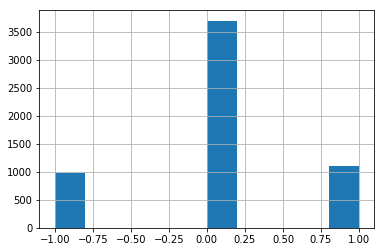

In [64]:
gold['target'].hist()

In [263]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

In [65]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
corn_gains = create_trade_outcomes(corn, 50)
corn_gains.head(5)

              gains     Open     High      Low   Settle
Date                                                   
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0


,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5


In [264]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

5790 2029 0.35043177892918825


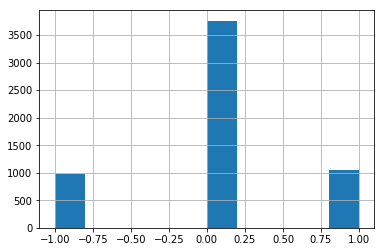

In [219]:
treshold = 180

get_wr(corn, 14)
corn_label = create_labels(corn_gains, treshold)
corn['target'] = corn_label.target
tot, trade = corn.shape[0], corn[corn.target != 0].shape[0]
print(tot, trade, float(trade/tot))

corn.target.hist()

In [220]:
corn.head(5)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,371.00,375.25,370.25,373.25,258495.0,1466855.0,40.000000,-1.0
1996-01-03,373.00,374.50,370.25,374.00,259050.0,1426400.0,25.000000,0.0
1996-01-04,373.50,373.75,365.00,369.00,392195.0,1389390.0,60.975610,-1.0
1996-01-05,366.75,369.00,365.50,366.50,245720.0,1359685.0,85.365854,1.0
1996-01-08,364.50,364.50,360.00,360.50,297685.0,1329650.0,96.721311,-1.0


In [221]:
# coffee contract size is 37,500 pounds price is in cents per pound
coffee_gains = create_trade_outcomes(coffee, 375)
coffee_gains.head(5)

                gains     Open      High      Low    Settle
Date                                                       
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50


,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75


In [266]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

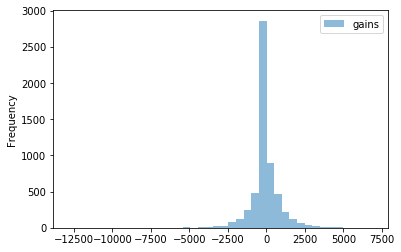

In [274]:
coffee_gains[['gains']].plot.hist(bins=40, alpha=0.5)

5752 2004 0.34840055632823363


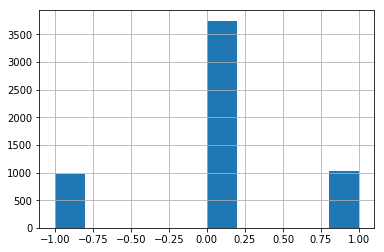

In [222]:
treshold = 275

get_wr(coffee, 14)
coffee_label = create_labels(coffee_gains, treshold)
coffee['target'] = coffee_label.target
tot, trade = coffee.shape[0], coffee[coffee.target != 0].shape[0]
print(tot, trade, float(trade/tot))

coffee.target.hist()

In [223]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-11,97.50,103.50,97.25,103.05,10130.0,17662.0,3.435115,-1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-18,103.80,107.25,102.25,105.40,8355.0,16314.0,10.979228,1.0
1996-01-22,104.65,107.80,104.25,107.50,6321.0,15322.0,1.724138,1.0
1996-01-23,107.25,109.40,106.60,107.00,6907.0,15103.0,12.631579,1.0


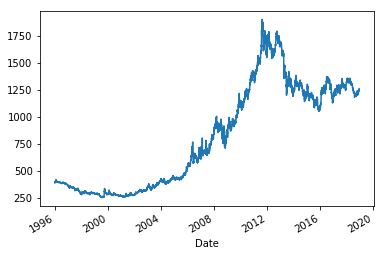

In [224]:
gold['Open'].plot()

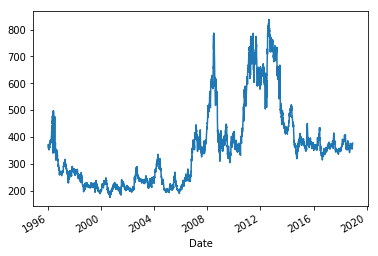

In [225]:
corn['Open'].plot()

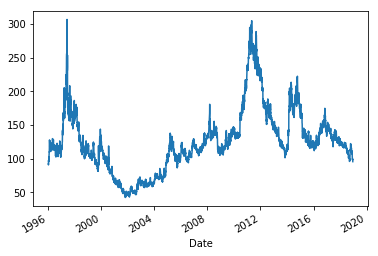

In [226]:
coffee['Open'].plot()

In [227]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [228]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [229]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,-1.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,-1.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,0.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,1.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,-1.0


In [230]:
gold_data.shape

(5276, 3046)

In [231]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [232]:
gold_data = gold_data[gold_data.index >= '2007-01-01']
corn_data = corn_data[corn_data.index >= '2007-01-01']
coffee_data = coffee_data[coffee_data.index >= '2007-01-01']

In [233]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def data_split_pca_transform(df):
    label_index = 3045
    df_validate = df.loc['2016-01-01' <= df.index]
    df_data_tt = df.loc['2016-01-01' > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    pca = PCA(n_components=30, random_state=2234)
    pca.fit(df_train[list(range(3024))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_data_tt[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3024))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3025,label_index))].values), axis=1)
    return df_pca

In [234]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [235]:
gold_label_train.unique()

array([-1.,  0.,  1.])

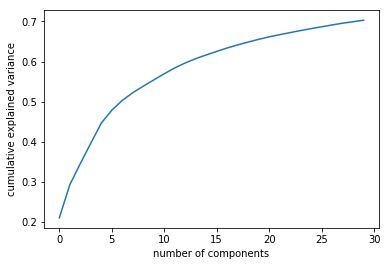

In [236]:
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [237]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [238]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [239]:
pca_components = 3

In [240]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [241]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [242]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=gold_label_train,) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=gold_label_test)
param = {'num_leaves':31, 'objective':'binary'}
param['metric'] = 'auc'
param['metric'] = 'rmse'
# param['boosting'] = 'dart'
param['max_bin'] = 40
num_round = 500
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

[1]	valid_0's rmse: 0.747383
[2]	valid_0's rmse: 0.74718
[3]	valid_0's rmse: 0.748625
[4]	valid_0's rmse: 0.748687
[5]	valid_0's rmse: 0.749312
[6]	valid_0's rmse: 0.749855
[7]	valid_0's rmse: 0.749795
[8]	valid_0's rmse: 0.749938
[9]	valid_0's rmse: 0.749355
[10]	valid_0's rmse: 0.749728
[11]	valid_0's rmse: 0.748783
[12]	valid_0's rmse: 0.749432
[13]	valid_0's rmse: 0.749496
[14]	valid_0's rmse: 0.750639
[15]	valid_0's rmse: 0.751623
[16]	valid_0's rmse: 0.752795
[17]	valid_0's rmse: 0.753218
[18]	valid_0's rmse: 0.754151
[19]	valid_0's rmse: 0.754464
[20]	valid_0's rmse: 0.754927
[21]	valid_0's rmse: 0.756016
[22]	valid_0's rmse: 0.756042
[23]	valid_0's rmse: 0.756877
[24]	valid_0's rmse: 0.757185
[25]	valid_0's rmse: 0.757112
[26]	valid_0's rmse: 0.756306
[27]	valid_0's rmse: 0.756817
[28]	valid_0's rmse: 0.757401
[29]	valid_0's rmse: 0.756807
[30]	valid_0's rmse: 0.757249
[31]	valid_0's rmse: 0.757346
[32]	valid_0's rmse: 0.758009
[33]	valid_0's rmse: 0.757798
[34]	valid_0's rmse:

[297]	valid_0's rmse: 0.772917
[298]	valid_0's rmse: 0.772772
[299]	valid_0's rmse: 0.772677
[300]	valid_0's rmse: 0.772848
[301]	valid_0's rmse: 0.772955
[302]	valid_0's rmse: 0.773191
[303]	valid_0's rmse: 0.772854
[304]	valid_0's rmse: 0.772904
[305]	valid_0's rmse: 0.773144
[306]	valid_0's rmse: 0.773256
[307]	valid_0's rmse: 0.773328
[308]	valid_0's rmse: 0.77364
[309]	valid_0's rmse: 0.773647
[310]	valid_0's rmse: 0.773719
[311]	valid_0's rmse: 0.773872
[312]	valid_0's rmse: 0.774118
[313]	valid_0's rmse: 0.774425
[314]	valid_0's rmse: 0.774296
[315]	valid_0's rmse: 0.77387
[316]	valid_0's rmse: 0.773939
[317]	valid_0's rmse: 0.773809
[318]	valid_0's rmse: 0.773527
[319]	valid_0's rmse: 0.773908
[320]	valid_0's rmse: 0.774033
[321]	valid_0's rmse: 0.774188
[322]	valid_0's rmse: 0.774483
[323]	valid_0's rmse: 0.774853
[324]	valid_0's rmse: 0.775165
[325]	valid_0's rmse: 0.774961
[326]	valid_0's rmse: 0.775355
[327]	valid_0's rmse: 0.775467
[328]	valid_0's rmse: 0.775686
[329]	vali

In [244]:
X_test = pca_transform(gold_test, gold_pca)

# gold_clf.score(X_test, gold_label_test)

In [253]:
X = pca_transform(corn_train, corn_pca)

train_data = lgb.Dataset(X, label=corn_label_train, categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(corn_test, corn_pca)
test_data = lgb.Dataset(X_test, label=corn_label_test)
param = {'num_leaves':31, 'objective':'binary'}
# param['metric'] = 'auc'
param['metric'] = 'rmse'
param['max_bin'] = 50
num_round = 500
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
sample_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
dtrain = xgb.DMatrix(X, label=list(map(lambda x: x+1, corn_label_train)), weight=sample_weight)
test_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
dtest = xgb.DMatrix(X_test, label=list(map(lambda x: x+1, corn_label_test)), weight=test_weight)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
param = {'max_depth': 50, 'eta': 1, 'silent': 1}
param['booster'] = 'dart'
param['nthread'] = 3
param['objective'] = 'multi:softmax'
param['objective'] = 'reg:linear'
param['num_class'] = 3
param['eval_metric'] = 'mlogloss'
# corn_clf = xgb.train(param, dtrain, num_round, evallist)
# corn_clf = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, objective='reg:logistic',
#                              booster='dart', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
# print(np.unique(list(map(lambda x: (x+1)/2, corn_label_train))))
# corn_clf.fit(X, list(map(lambda x: (x+1)/2, corn_label_train)))

# corn_clf = AdaBoostClassifier(n_estimators=150, learning_rate=0.5, random_state=1100)
# corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# corn_clf = RandomForestClassifier(n_estimators=100, random_state=1100)
sample_weight = list(map(lambda x: 3 if x != 0 else 1, corn_label_train))
# corn_clf.fit(X, corn_label_train)
# corn_clf.predict(X)

/home/martin/virtualenvs/trading/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/virtualenvs/trading/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3040, 3041, 3042, 3043]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/martin/virtualenvs/trading/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's rmse: 0.80882
[2]	valid_0's rmse: 0.80829
[3]	valid_0's rmse: 0.807532
[4]	valid_0's rmse: 0.806589
[5]	valid_0's rmse: 0.805891
[6]	valid_0's rmse: 0.805994
[7]	valid_0's rmse: 0.806502
[8]	valid_0's rmse: 0.806541
[9]	valid_0's rmse: 0.806611
[10]	valid_0's rmse: 0.806735
[11]	valid_0's rmse: 0.806081
[12]	valid_0's rmse: 0.80546
[13]	valid_0's rmse: 0.805083
[14]	valid_0's rmse: 0.805485
[15]	valid_0's rmse: 0.804943
[16]	valid_0's rmse: 0.804054
[17]	valid_0's rmse: 0.803825
[18]	valid_0's rmse: 0.804517
[19]	valid_0's rmse: 0.804128
[20]	valid_0's rmse: 0.804798
[21]	valid_0's rmse: 0.803742
[22]	valid_0's rmse: 0.80343
[23]	valid_0's rmse: 0.80439
[24]	valid_0's rmse: 0.805171
[25]	valid_0's rmse: 0.804887
[26]	valid_0's rmse: 0.804741
[27]	valid_0's rmse: 0.804534
[28]	valid_0's rmse: 0.804163
[29]	valid_0's rmse: 0.804391
[30]	valid_0's rmse: 0.804358
[31]	valid_0's rmse: 0.803517
[32]	valid_0's rmse: 0.804044
[33]	valid_0's rmse: 0.804259
[34]	valid_0's rmse: 0.8

[271]	valid_0's rmse: 0.79996
[272]	valid_0's rmse: 0.7998
[273]	valid_0's rmse: 0.800079
[274]	valid_0's rmse: 0.800227
[275]	valid_0's rmse: 0.800851
[276]	valid_0's rmse: 0.801216
[277]	valid_0's rmse: 0.801141
[278]	valid_0's rmse: 0.800929
[279]	valid_0's rmse: 0.800926
[280]	valid_0's rmse: 0.801111
[281]	valid_0's rmse: 0.800888
[282]	valid_0's rmse: 0.800466
[283]	valid_0's rmse: 0.800492
[284]	valid_0's rmse: 0.8005
[285]	valid_0's rmse: 0.80063
[286]	valid_0's rmse: 0.800751
[287]	valid_0's rmse: 0.801094
[288]	valid_0's rmse: 0.800883
[289]	valid_0's rmse: 0.800963
[290]	valid_0's rmse: 0.800989
[291]	valid_0's rmse: 0.801169
[292]	valid_0's rmse: 0.801478
[293]	valid_0's rmse: 0.801206
[294]	valid_0's rmse: 0.801187
[295]	valid_0's rmse: 0.801132
[296]	valid_0's rmse: 0.800925
[297]	valid_0's rmse: 0.800938
[298]	valid_0's rmse: 0.800911
[299]	valid_0's rmse: 0.800888
[300]	valid_0's rmse: 0.800878
[301]	valid_0's rmse: 0.800951
[302]	valid_0's rmse: 0.801058
[303]	valid_0'

In [254]:
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=coffee_label_train,) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=coffee_label_test)
param = {'num_leaves':31, 'objective':'binary'}
param['booster'] = 'gbtree'
param['metric'] = 'rmse'
param['max_bin'] = 50
num_round = 100
# coffee_clf = lgb.train(X, label=coffee_label_train)
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's rmse: 0.814145
[2]	valid_0's rmse: 0.814858
[3]	valid_0's rmse: 0.816211
[4]	valid_0's rmse: 0.816059
[5]	valid_0's rmse: 0.817646
[6]	valid_0's rmse: 0.817759
[7]	valid_0's rmse: 0.818512
[8]	valid_0's rmse: 0.818871
[9]	valid_0's rmse: 0.819532
[10]	valid_0's rmse: 0.820727
[11]	valid_0's rmse: 0.820891
[12]	valid_0's rmse: 0.822025
[13]	valid_0's rmse: 0.822222
[14]	valid_0's rmse: 0.82344
[15]	valid_0's rmse: 0.823548
[16]	valid_0's rmse: 0.823665
[17]	valid_0's rmse: 0.824391
[18]	valid_0's rmse: 0.823988
[19]	valid_0's rmse: 0.823812
[20]	valid_0's rmse: 0.824299
[21]	valid_0's rmse: 0.824042
[22]	valid_0's rmse: 0.824388
[23]	valid_0's rmse: 0.824572
[24]	valid_0's rmse: 0.824336
[25]	valid_0's rmse: 0.824631
[26]	valid_0's rmse: 0.825422
[27]	valid_0's rmse: 0.826033
[28]	valid_0's rmse: 0.826115
[29]	valid_0's rmse: 0.826599
[30]	valid_0's rmse: 0.826787
[31]	valid_0's rmse: 0.827027
[32]	valid_0's rmse: 0.827389
[33]	valid_0's rmse: 0.827651
[34]	valid_0's rmse:

In [255]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [256]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, xgb_use=False):
    global account_size, fee, stop_loss
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        predictions = model.predict(df)
    else:
        predictions = list(map(lambda x: x*2-1, model.predict(df)))
    dct = {}
    dct['account'] = [acc]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        if p > 0.5:
            if (v[1] - v[3]) > stop_loss:
                acc -= stop_loss
            else:
                acc += v[0] - fee
        elif p < -0.5:
            if (v[2] - v[1]) > stop_loss:
                acc -= stop_loss
            else:
                acc -= v[0] - fee
        dct['account'].append(acc)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

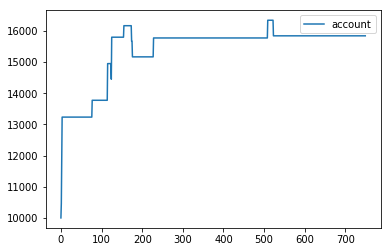

In [257]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains[gold_gains.index > '2016-01-01'], gold_validate, gold_label_validate)
gold_account.plot()

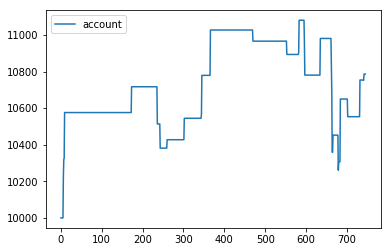

In [258]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains[corn_gains.index > '2016-01-01'], corn_validate, corn_label_validate, xgb_use=False)
corn_account.plot()

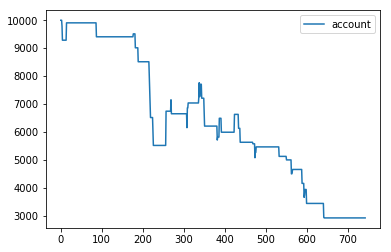

In [259]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains[coffee_gains.index > '2016-01-01'], coffee_validate, coffee_label_validate)
coffee_account.plot()